### extract apo chains from AF predicitons 

In [4]:
from Bio.PDB import PDBParser, PDBIO, Select
import sys
import os

class ChainSelect(Select):
    def __init__(self, chain_ids):
        self.chain_ids = set(chain_ids)

    def accept_chain(self, chain):
        return chain.id in self.chain_ids

def extract_chains(input_pdb, output_pdb, chains_to_extract):
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure("structure", input_pdb)

    io = PDBIO()
    io.set_structure(structure)
    io.save(output_pdb, ChainSelect(chains_to_extract))

# specify the receptor and ligand chains here
receptor_chains = "ABC"
ligand_chains = "DE"

work_dir = "/home/lwang/AI-HDX-main/ProteinComplex_HDX_prediction/example/AF_Cov19_icoHu23/structures"
os.makedirs(os.path.join(work_dir,"rec"), exist_ok=True)
os.makedirs(os.path.join(work_dir,"lig"), exist_ok=True)

for pdb in os.listdir(work_dir):
    if pdb.endswith(".pdb"):
        pdb = pdb[:-4]
        pdb_path = os.path.join(work_dir, pdb + ".pdb")
        parts = pdb.split("_")
        prefix = "_".join(parts[:-3]).upper()
        suffix = "_".join(parts[-3:]).upper()
        rec_pdb_path = os.path.join(work_dir, "rec", prefix + "_REC_" + suffix + ".pdb")
        lig_pdb_path = os.path.join(work_dir, "lig", prefix + "_LIG_" + suffix + ".pdb")
        extract_chains(pdb_path, rec_pdb_path, receptor_chains)
        extract_chains(pdb_path, lig_pdb_path, ligand_chains)

#### Run main.py with input of BatchAF_rec_setting.xml/ BatchAF_lig_setting.xml/ BatchAF_setting.xml separately.
#### output predictions to the folder ./predictions

In [99]:
## utilities
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr
from matplotlib.ticker import AutoMinorLocator

def parse_predictions(n, pred_dir, fsuffix='prediction_HDXRank', col_list=['Y_Pred_short', 'Y_Pred_middle','Y_Pred_long']):
    dfs = []
    for i in range(n):
        fpath = f'{pred_dir}/{fsuffix}_v{i}'
        df = pd.read_csv(fpath)
        print(df.shape)
        dfs.append(df)
    merged_df = pd.concat(dfs, axis=0)
    average_df = merged_df.groupby(['Batch', 'Chain', 'Range', 'Y_True'])[col_list].mean().reset_index()
    return average_df


# plot HDX difference and find potential HDX epitopes
def plot_HDX_diff(true_diff, diff_mtx, size=(10, 6)):
    plt.figure(figsize=size)
    x_labels = list(true_diff.keys())
    x_positions = np.arange(len(x_labels))  # numerical positions for x-axis

    diff = np.array(list(true_diff.values()))
    diff_neg = diff[diff<0]
    mean_diff = np.mean(diff_neg)
    hdx_epitope_id = np.where(diff<mean_diff)[0]
    hdx_epitope_pep = [x_labels[i] for i in hdx_epitope_id]

    plt.xticks(x_positions, x_labels, rotation=90)  # apply labels with rotation for clarity
    all_times = set()
    for diffs in diff_mtx.values():
        all_times.update(diffs.keys())
    sorted_times = sorted(all_times, key=lambda x: float(x))
    for time in sorted_times:
        time_values = [diff_mtx[label].get(time, 0) / 100 for label in x_labels]
        plt.plot(x_positions, time_values, label=f'time_{time}', linestyle='--', alpha=1)
    plt.plot(x_positions, list(true_diff.values()), label='True diff', color='k', marker='o', linestyle='-', linewidth=1, markersize=4)
    plt.ylabel('RFU difference')
    plt.axhline(y=mean_diff, color='r', linestyle='--', label='Epitope cutoff')
    #plt.grid(True)
    plt.legend()
    plt.show()
    return hdx_epitope_id, hdx_epitope_pep, sorted_times

# get average uptake from source HDX file
# return true_diff dictionary =  [Range]: diff

def get_true_diff(HDX_fpath, apo_states, complex_states, cluster_id=1, timepoints=[1,6]):
    def get_weighted_uptake(HDX_df, protein, state, correction):
        temp_HDX_df = HDX_df[(HDX_df['state']==state) & (HDX_df['protein']==protein)]
        if cluster_id == 0:
            temp_HDX_df = temp_HDX_df[temp_HDX_df['log_t']<timepoints[0]]
        elif cluster_id == 1:
            temp_HDX_df = temp_HDX_df[(temp_HDX_df['log_t']<timepoints[1]) & (temp_HDX_df['log_t']>=timepoints[0])]
        elif cluster_id == 2:
            temp_HDX_df = temp_HDX_df[(temp_HDX_df['log_t']>=timepoints[1])]
        else:
            raise ValueError('Invalid cluster_id')
        
        temp_HDX_df = temp_HDX_df.sort_values(by=['start', 'end'], ascending=[True, True])

        exposures = temp_HDX_df['exposure'].unique()
        unweighted_RFU = {time:{} for time in exposures}
        for time in exposures:
            for index, row in temp_HDX_df[temp_HDX_df['exposure']==time].iterrows():
                #chain_id = int(row['Chain'])
                unweighted_RFU[time][f'{row["start"]+correction}-{row["end"]+correction}'] = row['RFU']

        grouped = temp_HDX_df.groupby(['start', 'end'])
        weighted_uptake = grouped['RFU'].mean().to_numpy()/100 # average over identical chains
        unique_pairs = grouped.groups.keys()
        x_label = [f'{start+correction}-{end+correction}' for start, end in unique_pairs]

        return weighted_uptake, x_label, unweighted_RFU
    
    HDX_df = pd.read_excel(HDX_fpath)
    true_apo, true_complex = {}, {}
    apo_mtx, complex_mtx = {}, {}

    protein, state, correction = apo_states[0], apo_states[1], apo_states[2]
    uptake, label, U_apo_mtx = get_weighted_uptake(HDX_df, protein, state, correction)
    for l, u in zip(label, uptake):
        true_apo[l] = u
    apo_mtx.update(U_apo_mtx)

    protein, state, correction = complex_states[0], complex_states[1], complex_states[2]
    uptake, label, U_complex_mtx = get_weighted_uptake(HDX_df, protein, state, correction)
    for l, u in zip(label, uptake):
        true_complex[l] = u
    complex_mtx.update(U_complex_mtx)

    true_diff = {}
    diff_mtx = {}
    for key in true_apo.keys():
        if key in true_complex:
            true_diff[key] = true_complex[key] - true_apo[key]
            diff_mtx[key] = {t: complex_mtx[t][key] - apo_mtx[t][key] for t in apo_mtx if key in apo_mtx[t] and key in complex_mtx[t]}
    
    print('Common peptides num:', len(true_diff.keys()))
    return true_diff, diff_mtx

# run DockQ to evaluate the quality of Hdock decoys
from DockQ.DockQ import load_PDB, run_on_all_native_interfaces

def merge_chains(model, chains_to_merge):
    for chain in chains_to_merge[1:]:
        for i, res in enumerate(model[chain]):
            res.id = (chain, res.id[1], res.id[2])
            model[chains_to_merge[0]].add(res)
        model.detach_child(chain)
    model[chains_to_merge[0]].id = "".join(chains_to_merge)
    return model

def run_dockq(native_fpath, model_dir, model_list, mapping):
    dockq_results = {}
    native = load_PDB(native_fpath)
    #native = merge_chains(native, ["A", "B"])
    for model in model_list:
        if not model.endswith('.pdb'):
            continue
        model_fpath = f'{model_dir}/{model}'
        structure = load_PDB(model_fpath)
        #structure = merge_chains(structure, ["A", "B"])
        result = run_on_all_native_interfaces(structure, native, chain_map=mapping)
        data = list(result[0].values())[0]
        dockq_results[model.split('.')[0]] = [data['DockQ'], data['irms'], data['Lrms'], data['fnat']]
    return dockq_results

In [92]:
work_dir = "/home/lwang/AI-HDX-main/ProteinComplex_HDX_prediction/example/AF_Cov19_icoHu23/predictions"
HDX_fpath = "/home/lwang/AI-HDX-main/ProteinComplex_HDX_prediction/example/AF_Cov19_icoHu23/HDX_files/Wuhan_icoHu23.xlsx"
pred_cluster = 1
clusters = {0: 'short', 1: 'middle', 2: 'long'}

complex_pred_df = parse_predictions(5, f'{work_dir}', fsuffix='prediction_graph_ensemble_GearNet_hse_HDXRank')
rec_pred_df = parse_predictions(5, f'{work_dir}', fsuffix='prediction_rec_graph_ensemble_GearNet_hse_HDXRank')

diff_df = pd.DataFrame()
for seed in range(1, 11):
    for model in range(5):
        batch_id_complex = f'fold_1203_wuhan_icohu104_seed{seed}_model_{model}'.upper()
        batch_id_rec = f'fold_1203_wuhan_icohu104_rec_seed{seed}_model_{model}'.upper()

        temp_df = complex_pred_df[complex_pred_df['Batch'] == batch_id_complex].groupby(['Range'])[f'Y_Pred_{clusters[pred_cluster]}'].mean()
        temp_apo_df = rec_pred_df[rec_pred_df['Batch'] == batch_id_rec].groupby(['Range'])[f'Y_Pred_{clusters[pred_cluster]}'].mean()

        aligned_df = pd.concat([temp_df.rename('Y_Pred_complex'), temp_apo_df.rename('Y_Pred_apo')],
                                axis=1).dropna().reset_index()

        aligned_df['Y_Pred_diff'] = aligned_df['Y_Pred_complex'] - aligned_df['Y_Pred_apo']
        aligned_df['Batch'] = batch_id_complex
        diff_df = pd.concat([diff_df, aligned_df], axis=0)


(7200, 7)
(7200, 7)
(7200, 7)
(7200, 7)
(7200, 7)
(7200, 7)
(7200, 7)
(7200, 7)
(7200, 7)
(7200, 7)


('Wuhan_cov19', 'apo', 0, None) ('Wuhan_cov19', 'complex', 0, None)
Common peptides num: 48


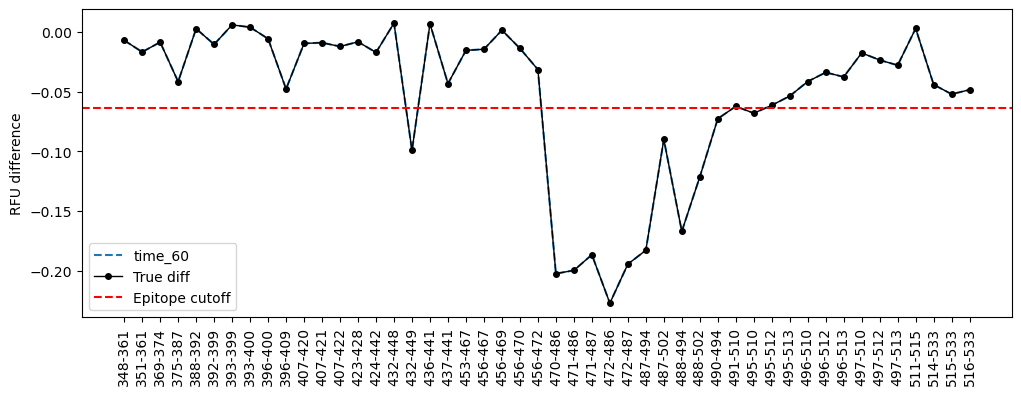

In [60]:
apo_states = {
    'protein': 'Wuhan_cov19',
    'state': 'apo',
    'correction': 0,
    'structure': None
}
complex_states = {
    'protein': 'Wuhan_cov19',
    'state': 'complex',
    'correction': 0,
    'structure': None
}
input_apo_states = [tuple(apo_states.values())]
input_complex_states = [tuple(complex_states.values())]

hdx_epitope_peps = []
hdx_true_diffs = []
for apo, complex in zip(input_apo_states, input_complex_states):
    print(apo, complex)
    true_diff, diff_mtx = get_true_diff(HDX_fpath, complex, apo, timepoints=[1,2]) # specific for this case/ HDX file record
    epitope_id, epitope_pep, hdx_times = plot_HDX_diff(true_diff, diff_mtx, size=(12,4))
    hdx_true_diffs.append(true_diff)
    hdx_epitope_peps.append(epitope_pep)

In [52]:
# ouput the HDX epitope peptides
def to_ranges(numbers):
    if not numbers:
        return []
    
    ranges = []
    start = numbers[0]
    prev = numbers[0]

    for num in numbers[1:]:
        if num == prev + 1:
            # Continue the current range
            prev = num
        else:
            # End of the current range
            ranges.append(f"{start}-{prev}" if start != prev else f"{start}")
            start = num
            prev = num
    
    # Add the last range
    ranges.append(f"{start}-{prev}" if start != prev else f"{start}")
    return ranges

def to_numbers(range_list):
    all_numbers = set()
    for r in range_list:
        start, end = map(int, r.split('-'))
        all_numbers.update(range(start, end + 1))
    return sorted(all_numbers)

for i, epitopes in enumerate(hdx_epitope_peps):
    all_numbers = to_numbers(epitopes)
    ranges = to_ranges(all_numbers)
    print(f'Epitopes for {input_apo_states[i][3]} and {input_complex_states[i][3]}:')
    print(ranges)

Epitopes for None and None:
['432-449', '470-510']


In [98]:
import numpy as np
import pandas as pd
from tqdm import tqdm

def mean_squared_error(y_true, y_pred, error_limit=1):
    return np.mean(((y_true - y_pred) / error_limit) ** 2)

def compute_hdx_score(df, complex_batch, hdx_true_diffs, hdx_epitope_peps=None, clusters=None):
    """
    Prepare and compute the HDX RMSE score between true and predicted HDX differences.

    Parameters:
    ----------
    df : pandas.DataFrame
        DataFrame containing predicted differences with columns ['Batch', 'Range', ...].
    complex_batch : str
        The batch identifier for the complex predictions.
    hdx_true_diffs : list of dict
        List containing dictionaries of true HDX differences, mapping peptides ('Range') to their true values.
    pred_cluster : int
        Index or identifier to specify which cluster prediction is being used.
    hdx_epitope_peps : list of lists, optional
        Lists containing peptides of interest. Defaults to all peptides present in each hdx_true_diff dictionary.
    clusters : list, optional
        List containing cluster labels or indices used to construct the column names.

    Returns:
    -------
    float
        Root Mean Squared Error (RMSE) between true and predicted HDX differences.
    """
    truth, pred = [], []

    if complex_batch not in df['Batch'].values:
        print(f'Batch "{complex_batch}" not found in prediction data.')
        return None

    if clusters is None:
        raise ValueError("clusters parameter must be provided")

    pred_column = f'Y_Pred_diff'

    if pred_column not in df.columns:
        raise ValueError(f'Column "{pred_column}" not found in DataFrame.')

    complex_df = df[df['Batch'] == complex_batch]
    if hdx_epitope_peps is None:
        hdx_epitope_peps = [list(hdx_dict.keys()) for hdx_dict in hdx_true_diffs]

    for epitope_peps, hdx_dict in zip(hdx_epitope_peps, hdx_true_diffs):
        for pep in epitope_peps:
            pred_row = complex_df.loc[complex_df['Range'] == pep]
            if not pred_row.empty:
                pred_diff = pred_row[pred_column].values[0]
                true_diff = hdx_dict[pep]
                truth.append(true_diff)
                pred.append(pred_diff)

    if not truth or not pred:
        print('No matching peptides found for computation.')
        return None

    rmse = mean_squared_error(np.array(truth), np.array(pred))
    return rmse

HDX_scores = {}
for complex_batch in tqdm(diff_df['Batch'].unique()):
    score = compute_hdx_score(diff_df, complex_batch, hdx_true_diffs, hdx_epitope_peps = hdx_epitope_peps, clusters=clusters)
    HDX_scores[complex_batch] = score

100%|██████████| 50/50 [00:00<00:00, 172.34it/s]


In [ ]:
## dockq df
model_dir = f'/home/lwang/AI-HDX-main/ProteinComplex_HDX_prediction/example/AF_Cov19_icoHu23/structures'
native_fpath = f"/home/lwang/models/HDX_LSTM/data/Cov19_icoHu23/structure/8elj.pdb"
model_list = [file for file in os.listdir(model_dir) if file.endswith('.pdb')]
mappings = [{'S': 'D', 'T':'E'},
            {'W': 'D', 'X':'E'},
            {'U': 'D', 'V':'E'},]

dockq_combine = []
for mapping in mappings:
    dockq_results = run_dockq(native_fpath, model_dir, model_list, mapping)
    dockq_df = pd.DataFrame(dockq_results).T
    dockq_df.columns = ['DockQ', 'irms', 'Lrms', 'fnat']
    dockq_df['model'] = dockq_df.index
    dockq_combine.append(dockq_df)

In [122]:
from DockQ.DockQ import load_PDB, run_on_all_native_interfaces

def merge_chains(model, chains_to_merge):
    for chain in chains_to_merge[1:]:
        for i, res in enumerate(model[chain]):
            res.id = (chain, res.id[1], res.id[2])
            model[chains_to_merge[0]].add(res)
        model.detach_child(chain)
    model[chains_to_merge[0]].id = "".join(chains_to_merge)
    return model

model_dir = f'/home/lwang/AI-HDX-main/ProteinComplex_HDX_prediction/example/AF_Cov19_icoHu23/structures'
native_fpath = f"/home/lwang/models/HDX_LSTM/data/Cov19_icoHu23/structure/8elj.pdb"
model_list = [file for file in os.listdir(model_dir) if file.endswith('.pdb')]
mapping = [{"C": "C", "WX": "DE"}, {"B": "A", "ST": "DE"}, {"A": "B", "UV": "DE"}]
merge_list = [["W", "X"], ["S", "T"], ["U", "V"]]

dockq_combine = []
for i in range(3):
    dockq_results = {}
    native = load_PDB(native_fpath)
    native = merge_chains(native, merge_list[i])
    for file in model_list:   
        pdb_path = os.path.join(model_dir, file)
        model = load_PDB(pdb_path)
        model = merge_chains(model, ["D", "E"])
        result = run_on_all_native_interfaces(model, native, chain_map=mapping[i])
        data = list(result[0].values())[0]
        dockq_results[file.split('.')[0]] = [data['DockQ'], data['irms'], data['Lrms'], data['fnat']]
    dockq_df = pd.DataFrame(dockq_results).T
    dockq_df.columns = ['DockQ', 'irms', 'Lrms', 'fnat']
    dockq_df['model'] = dockq_df.index
    dockq_combine.append(dockq_df)

In [123]:
hdx_score_df = pd.DataFrame(HDX_scores.items(), columns=['model', 'HDX_score'])
hdx_score_df = hdx_score_df.sort_values(by='HDX_score')

dockq_combine_merge = pd.concat(dockq_combine, ignore_index=True)
# Group by 'model' and take the minimum for specified metrics
dockq_df = dockq_combine_merge.groupby('model', as_index=False).agg({
    'DockQ': 'max',
    'irms': 'min',
    'Lrms': 'min',
    'fnat': 'max'
})

merge_df = pd.merge(dockq_df, hdx_score_df, on='model')
merge_df = merge_df.sort_values(by='HDX_score')
display(merge_df)

,model,DockQ,irms,Lrms,fnat,HDX_score
26,FOLD_1203_WUHAN_ICOHU104_SEED5_MODEL_1,0.347823,3.369087,6.936458,0.277778,0.011820
31,FOLD_1203_WUHAN_ICOHU104_SEED6_MODEL_1,0.023851,15.922073,32.848356,0.000000,0.011956
46,FOLD_1203_WUHAN_ICOHU104_SEED9_MODEL_1,0.308963,2.764832,16.301112,0.485714,0.013323
29,FOLD_1203_WUHAN_ICOHU104_SEED5_MODEL_4,0.268013,4.112154,11.500722,0.333333,0.013412
27,FOLD_1203_WUHAN_ICOHU104_SEED5_MODEL_2,0.279342,3.629731,12.082946,0.361111,0.015544
33,FOLD_1203_WUHAN_ICOHU104_SEED6_MODEL_3,0.221744,4.750934,12.261442,0.250000,0.015736
0,FOLD_1203_WUHAN_ICOHU104_SEED10_MODEL_0,0.316295,3.697029,9.665391,0.371429,0.015994
21,FOLD_1203_WUHAN_ICOHU104_SEED4_MODEL_1,0.332240,2.639726,13.616288,0.472222,0.016812
4,FOLD_1203_WUHAN_ICOHU104_SEED10_MODEL_4,0.002298,44.041583,111.753375,0.000000,0.017487
7,FOLD_1203_WUHAN_ICOHU104_SEED1_MODEL_2,0.020751,14.443061,36.448038,0.000000,0.017522


### Clustering AF predictions

In [109]:
import sys
sys.path.append('/home/lwang/models/HDX_LSTM/models/HDXRank/')
from tool.pdb2sql.StructureSimilarity import StructureSimilarity
from tool.pdb2sql import pdb2sql
from tool.pdb2sql.superpose import superpose
from tool.pdb2sql.many2sql import many2sql

from Bio.PDB import *
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import os

In [113]:
clustering_setting = {
    'protein_name': '',
    'N': 50,
    'min_leaf_size': 2,
    'bindingsite_cutoff': 10.0,  # coarse cutoff to allow orientation variation at a close binding site
    'pose_rmsd_cutoff': 15.0,
    'atom_type_list': ['CA'],
    'lig_chains': ['D', 'E']
}

AF_dir = f'/home/lwang/AI-HDX-main/ProteinComplex_HDX_prediction/example/AF_Cov19_icoHu23/structures'
pdb_fpaths = [os.path.join(AF_dir, file) for file in os.listdir(AF_dir) if file.endswith('.pdb')]

# Initialize RMSD matrix
num_pdbs = len(pdb_fpaths)
lrmsd_mtx = np.zeros((num_pdbs, num_pdbs))

# Extract ligand coordinates after superposition
coords = []
reference = pdb2sql(pdb_fpaths[0])

for pdb in pdb_fpaths:
    mobile = pdb2sql(pdb)
    overlap_mobile = superpose(mobile, reference, export=False, chainID=['A','B','C'])
    overlap_mobile_lig = overlap_mobile.get('x,y,z', chainID=clustering_setting['lig_chains'])
    coords.append(np.array(overlap_mobile_lig))

coords = np.array(coords)

# Compute RMSD matrix
for i in range(num_pdbs):
    ref_coords = coords[i]
    for j in range(i + 1, num_pdbs):
        check_coords = coords[j]
        lrmsd = StructureSimilarity.get_rmsd(ref_coords, check_coords)
        lrmsd_mtx[i, j] = lrmsd
        lrmsd_mtx[j, i] = lrmsd  # symmetric matrix

print(lrmsd_mtx)


[[  0.     92.885  79.74  ... 122.292  57.686 118.777]
 [ 92.885   0.    122.548 ...  91.672 127.359  88.204]
 [ 79.74  122.548   0.    ...  87.73   49.62  119.263]
 ...
 [122.292  91.672  87.73  ...   0.    122.363  88.395]
 [ 57.686 127.359  49.62  ... 122.363   0.    124.366]
 [118.777  88.204 119.263 ...  88.395 124.366   0.   ]]


<Figure size 1000x600 with 0 Axes>

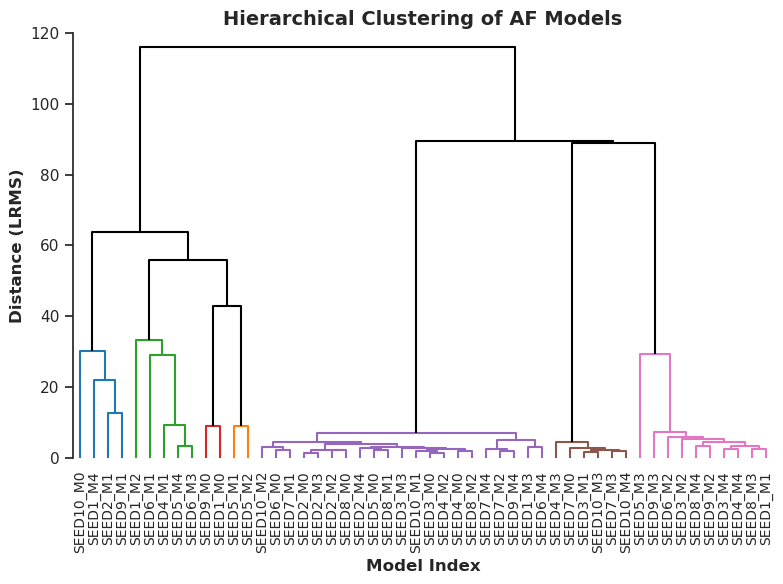

In [133]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster,set_link_color_palette
from scipy.spatial.distance import squareform
import matplotlib.pyplot as plt
import numpy as np

# Perform hierarchical clustering
condensed_rmsd = squareform(lrmsd_mtx)
linkage_matrix = linkage(condensed_rmsd, method='average')

num_clusters = 7
clusters = fcluster(linkage_matrix, num_clusters, criterion='maxclust')

# Plot the dendrogram with cluster colors
plt.figure(figsize=(10, 6))
custom_palette = ["tab:blue", "tab:green", "tab:red", "tab:orange",  "tab:purple", "tab:brown", "tab:pink"]
set_link_color_palette(custom_palette)
cluster_color_map = {cluster: color for cluster, color in zip(np.unique(clusters), custom_palette)}

custom_labels = []
for file in pdb_fpaths:
    pdb_splits = os.path.basename(file).split('_')
    seed = pdb_splits[-3].replace('seed', 'S')
    label = seed+'_M'+pdb_splits[-1][0]
    custom_labels.append(label)

# Plot the dendrogram with unified cluster colors
fig, ax = plt.subplots(figsize=(8, 6))
dendro = dendrogram(
    linkage_matrix,
    labels=custom_labels,
    color_threshold=linkage_matrix[-(num_clusters - 1), 2],
    leaf_rotation=90,
    leaf_font_size=10,
    above_threshold_color="black",  # Color for branches above the clustering threshold
    ax=ax,
)

for spine_name, spine in ax.spines.items():
    if spine_name != 'left':
        spine.set_visible(False)

plt.title("Hierarchical Clustering of AF Models", fontsize=14, fontweight="bold")
plt.xlabel("Model Index", fontsize=12, fontweight="bold")
plt.ylabel("Distance (LRMS)", fontsize=12, fontweight="bold")
plt.ylim(0,120)
plt.tight_layout()
#plt.savefig(f'/home/lwang/models/HDX_LSTM/data/Cov19_icoHu23/AF_50/AF_Clustering_dendrogram.png', dpi=300, transparent=True)
plt.show()
set_link_color_palette(None)

In [124]:
cluster_df = pd.DataFrame()
cluster_df['model'] = [os.path.basename(pdb)[:-4] for pdb in pdb_fpaths]
cluster_df['Cluster'] = clusters

cluster_df = pd.merge(cluster_df, merge_df, on='model').sort_values(by='HDX_score')
display(cluster_df)

,model,Cluster,DockQ,irms,Lrms,fnat,HDX_score
19,FOLD_1203_WUHAN_ICOHU104_SEED5_MODEL_1,4,0.347823,3.369087,6.936458,0.277778,0.011820
24,FOLD_1203_WUHAN_ICOHU104_SEED6_MODEL_1,2,0.023851,15.922073,32.848356,0.000000,0.011956
39,FOLD_1203_WUHAN_ICOHU104_SEED9_MODEL_1,1,0.308963,2.764832,16.301112,0.485714,0.013323
22,FOLD_1203_WUHAN_ICOHU104_SEED5_MODEL_4,2,0.268013,4.112154,11.500722,0.333333,0.013412
20,FOLD_1203_WUHAN_ICOHU104_SEED5_MODEL_2,4,0.279342,3.629731,12.082946,0.361111,0.015544
26,FOLD_1203_WUHAN_ICOHU104_SEED6_MODEL_3,2,0.221744,4.750934,12.261442,0.250000,0.015736
43,FOLD_1203_WUHAN_ICOHU104_SEED10_MODEL_0,1,0.316295,3.697029,9.665391,0.371429,0.015994
14,FOLD_1203_WUHAN_ICOHU104_SEED4_MODEL_1,2,0.332240,2.639726,13.616288,0.472222,0.016812
47,FOLD_1203_WUHAN_ICOHU104_SEED10_MODEL_4,6,0.002298,44.041583,111.753375,0.000000,0.017487
0,FOLD_1203_WUHAN_ICOHU104_SEED1_MODEL_2,2,0.020751,14.443061,36.448038,0.000000,0.017522


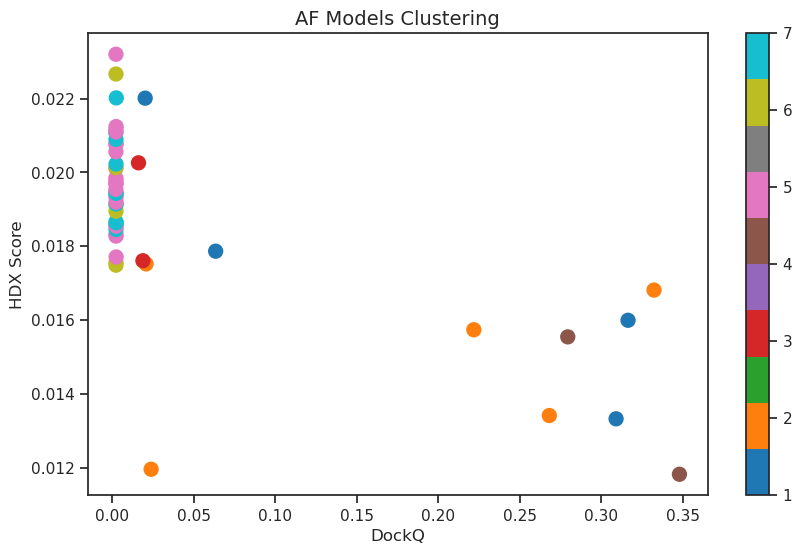

In [128]:
plt.figure(figsize=(10, 6))
plt.scatter(cluster_df['DockQ'], cluster_df['HDX_score'], c=cluster_df['Cluster'], cmap='tab10', s=100)
plt.xlabel('DockQ', fontsize=12)
plt.ylabel('HDX Score', fontsize=12)
plt.title('AF Models Clustering', fontsize=14)
plt.colorbar()
plt.show()


In [98]:
print(cluster_color_map)

{1: 'tab:blue', 2: 'tab:green', 3: 'tab:orange', 4: 'tab:red', 5: 'tab:purple', 6: 'tab:brown', 7: 'tab:pink'}


,Cluster,HDX_score,DockQ
0,1,0.586423,0.177220
1,2,0.227890,0.173320
2,3,0.851527,0.017459
3,4,0.000000,0.313582
4,5,1.000000,0.002303
5,6,0.913857,0.002306
6,7,0.992007,0.002322


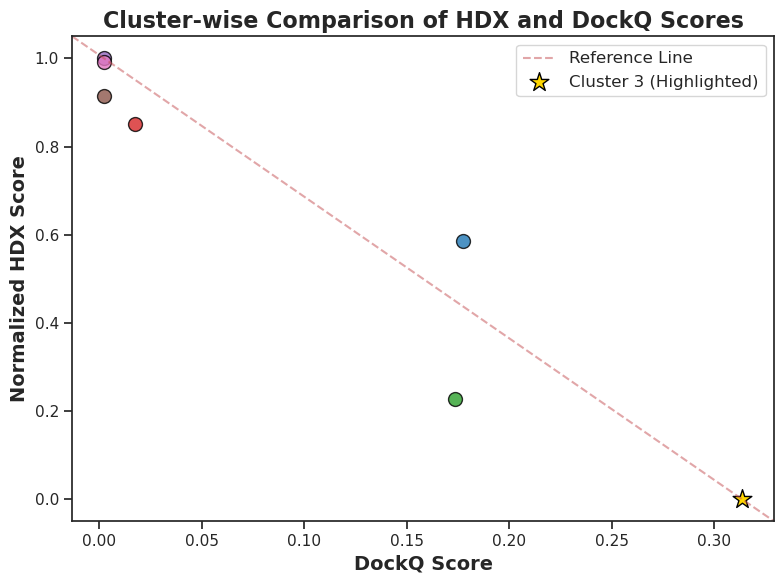

In [134]:
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

scaler = MinMaxScaler()

mean_values = (
    cluster_df.groupby('Cluster')[['HDX_score', 'DockQ']]
    .mean()
    .reset_index()
)
mean_values['HDX_score'] = scaler.fit_transform(mean_values[['HDX_score']])
display(mean_values)
highlight_cluster = mean_values.loc[mean_values['DockQ'].idxmax(), 'Cluster']

plt.figure(figsize=(8, 6))
sns.set(style="ticks")
palette = iter(sns.color_palette("tab10", n_colors=mean_values['Cluster'].nunique()-1))
for index, row in mean_values.iterrows():
    if row['Cluster'] == highlight_cluster:
        plt.scatter(
            row['DockQ'], 
            row['HDX_score'], 
            s=200, 
            color='gold', 
            edgecolor='black', 
            marker='*', 
            label=f'Cluster 3 (Highlighted)'
        )
    else:
        set_color = cluster_color_map[int(row['Cluster'])]
        plt.scatter(
            row['DockQ'], 
            row['HDX_score'], 
            s=100, 
            color=set_color, 
            edgecolor='black', 
            alpha=0.8
        )

plt.plot([0, 1], [1, 0], transform=plt.gca().transAxes, color='r', linestyle='--', alpha=0.5, label="Reference Line")

plt.ylabel('Normalized HDX Score', fontsize=14, fontweight='bold')
plt.xlabel('DockQ Score', fontsize=14, fontweight='bold')
plt.title("Cluster-wise Comparison of HDX and DockQ Scores", fontsize=16, fontweight='bold')
plt.legend(loc='upper right', fontsize=12)
plt.tight_layout()
#plt.show()
plt.savefig(f'/home/lwang/AI-HDX-main/ProteinComplex_HDX_prediction/example/AF_Cluster_Comparison.png', dpi=300, transparent=False)

In [ ]:
import shutil

dst_dir = f'/home/lwang/models/HDX_LSTM/data/Cov19_icoHu23/ZRank2_top50'

for i, index in enumerate(clusters):
    if not os.path.exists(f'{dst_dir}/{spike_protein}/cluster{index}'):
        os.makedirs(f'{dst_dir}/{spike_protein}/cluster{index}')
    paths = pdb_fpaths[i].split('/')
    dst_file = f"{dst_dir}/{spike_protein}/cluster{index}/{paths[-2]+'_'+paths[-1]}"
    shutil.copyfile(pdb_fpaths[i], dst_file)